In [48]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt

# Import Utility Functions
from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.data.gcs_utils import GCSClient

from collab_env.alignment import reprojection, align

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load tracked data

In [3]:
data_type = 'fieldwork_processed'
session = '2024_02_06-session_0001'

session_data_dir = Path('/workspace/collab-environment/data/') / data_type / session
aligned_dir = session_data_dir / "aligned_frames" / "rgb_1"
mesh_dir = session_data_dir / "environment" / "C0043" / "rade-features" / "mesh"

mesh_fn = mesh_dir / "Open3dTSDFfusion_mesh.ply"

# Simulate bboxes for now
tracking_fn = aligned_dir / "rgb_1_tracked_bboxes.csv"

#"tracked_bboxes_1.csv"

df_tracks = pd.read_csv(tracking_fn)
df_tracks["track_id"] = df_tracks["track_id"].astype(int)

### Load camera parameters

In [4]:
import pickle

camera_params_fn = aligned_dir / "camera_params_mesh.pkl"

with open(camera_params_fn, 'rb') as f:
    camera_params = pickle.load(f)

camera = reprojection.Camera(
    K=camera_params['K'],
    c2w=camera_params['c2w'],
    width=camera_params['width'],
    height=camera_params['height']
)

In [50]:
camera_params

{'fx': 1109.7946537427067,
 'fy': 1109.7946537427067,
 'cx': 320.0,
 'cy': 240.0,
 'K': array([[782.80259244,   0.        , 323.37498319],
        [  0.        , 856.09813546, 241.53779294],
        [  0.        ,   0.        ,   1.        ]]),
 'height': 480,
 'width': 640,
 'c2w': array([[ 0.90700873,  0.06012743,  0.41679714, -0.35243207],
        [-0.41860535,  0.02090709,  0.90792756,  0.23637645],
        [ 0.04587734, -0.99797174,  0.04413258, -0.12466235],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

In [53]:
mesh_environment = reprojection.MeshEnvironment(mesh_fn)

# Also updates camera.image and camera.depth --> stores them so no need to re-render
image, depth = mesh_environment.render_camera(camera)

In [56]:
import numpy as np

def get_depths_in_bbox(depth_map, bbox):
    """
    Args:
        depth_map (np.ndarray): H x W array of depth values
        bbox (tuple): (x1, y1, x2, y2)
    
    Returns:
        np.ndarray: 2D array of depth values inside the bounding box
    """
    x1, y1, x2, y2 = map(int, bbox)
    return depth_map[y1:y2, x1:x2]

def get_bbox_pixel_indices(bbox, image_shape):
    """
    Get all (row, col) pixel indices inside a 2D bounding box.

    Args:
        bbox (tuple or list): Bounding box in (x1, y1, x2, y2) format (pixel coordinates).
        image_shape (tuple): (height, width) of the image to clamp indices.

    Returns:
        indices: (N, 2) array of (row, col) pixel indices within the bounding box.
    """
    x1, y1, x2, y2 = map(int, bbox)
    h, w = image_shape

    # Clamp to image boundaries
    x1 = np.clip(x1, 0, w - 1)
    x2 = np.clip(x2, 0, w - 1)
    y1 = np.clip(y1, 0, h - 1)
    y2 = np.clip(y2, 0, h - 1)

    # Generate grid of (row, col) indices
    rows = np.arange(y1, y2)
    cols = np.arange(x1, x2)
    rr, cc = np.meshgrid(rows, cols, indexing='ij')
    
    indices = np.stack([rr.ravel(), cc.ravel()], axis=1)  # shape (N, 2)
    
    return indices

def array_nan_equal(a, b):
    m = np.isfinite(a) & np.isfinite(b)
    return np.allclose(a[m], b[m])

bbox = df_tracks.loc[100, ['x1', 'y1', 'x2', 'y2']].values.astype(float)

bbox_indices = get_bbox_pixel_indices(bbox, camera.depth.shape)
bbox_indices_uv = bbox_indices[:, [1, 0]]  # swap columns to (u, v)

Given a bounding box --> project it to world coordinates

In [62]:
bbox = df_tracks.loc[100, ['x1', 'y1', 'x2', 'y2']].values.astype(float)

bbox_indices = get_bbox_pixel_indices(bbox, camera.depth.shape)
bbox_indices_uv = bbox_indices[:, [1, 0]]  # swap columns to (u, v)

world_points = camera.project_to_world(bbox_indices_uv)

/workspace/collab-environment/collab_env/alignment/reprojection.py:124: RuntimeWarning: invalid value encountered in matmul
  points_world_hom = (self.c2w @ points_cam.T).T


Demonstrate that we recover the original image

In [65]:
# Get the depth values in the bounding box
box_depth = get_depths_in_bbox(camera.depth, bbox)

# Project the world points to the camera --> this should recover the depths of the original image
points2d, depths = camera.project_to_camera(world_points)

# Reshape the points to the bounding box shape
x1, y1, x2, y2 = bbox.astype(int)
h, w = y2 - y1, x2 - x1

depth_patch = depths.reshape(h, w)

# Check if the depths are the same
same_depths = array_nan_equal(box_depth, depth_patch)

print (f"Equal depths: {same_depths}")

Equal depths: True


#### Create an agent

In [9]:
# Agent consists of an initial position and size via a bounding box

position, size = reprojection.bbox_to_world(camera, bbox, method='bottom_center', bottom_fraction=0.1)

agent = reprojection.Agent(position, size)

1. Map all bounding boxes to 3d tracks (can see if it makes sense on the mesh)
    - Visualize in 3d --> does it make sense?
2. plot apparent size (area of bounding box) vs. estimated depth (world coordinate)
    - for each track
    - need to ensure there's a relationship otherwise no signal to estimate true size

3. Preprocessing --> finding number of frames on the mesh
    - What is the data we are conditioning on? The frames that we are picking w/ more certainty
    - Movement generator becomes an entirely 3D
    - Do we care about accurate 3d tracks? Or the size?

4. If 3d is noisy --> we want to separate GT from noise
    - Our model is "size changing bc of depth" --> check for tracks that we understand what is going on
    - Then size works as a regularizer for tracks

What do we do with the reprojected?

- We find ones w/ high confidence and use those as priors on the initial position

In [123]:
cam_pos = camera.c2w[:3, 3]
print("Camera position:", cam_pos)

forward = camera.c2w[:3, 2]  # +Z in camera space
print("Camera forward:", forward)

mesh_center = mesh_environment.mesh.get_center()
vec_to_mesh = mesh_center - cam_pos
cos_angle = np.dot(vec_to_mesh, forward) / (np.linalg.norm(vec_to_mesh) * np.linalg.norm(forward))
print("Cosine of angle between camera forward and mesh:", cos_angle)

Camera position: [-0.35243207  0.23637645 -0.12466235]
Camera forward: [0.41679714 0.90792756 0.04413258]
Cosine of angle between camera forward and mesh: 0.9882686527084776


In [1]:
colors, depths = render_camera_with_points(mesh_environment.mesh, camera, points)

NameError: name 'render_camera_with_points' is not defined

In [139]:
plt.imshow(colors)

: 

In [10]:
import numpy as np

def get_camera_depth_direction(c2w: np.ndarray) -> np.ndarray:
    """
    Get the depth direction of the camera in world coordinates.

    Args:
        c2w: (4,4) camera-to-world transformation matrix

    Returns:
        depth_dir: (3,) unit vector pointing along the camera's forward axis (depth)
    """
    # Camera +Z axis in world space is the forward/depth direction
    depth_dir = c2w[:3, 2]
    depth_dir /= np.linalg.norm(depth_dir)  # normalize to unit vector
    return depth_dir

[-0.17097134  0.72992482 -0.23965566]


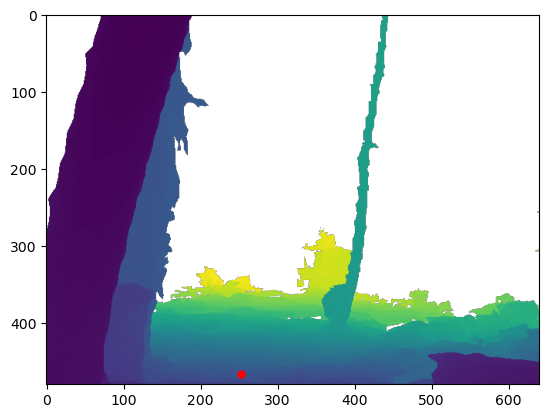

In [69]:
df_filtered = df_tracks[df_tracks['track_id'] == 994]

bbox = df_filtered.loc[100, ['x1', 'y1', 'x2', 'y2']].values.astype(float)

point, shape = reprojection.bbox_to_world(camera, bbox, method='bottom_center', bottom_fraction=0.1)
print (point)

xy, depth = camera.project_to_camera(np.asarray(point)[np.newaxis, :])

plt.imshow(camera.depth)
plt.scatter(xy[:, 0], xy[:, 1], s=25, c='r')

#### Test size/depth relationship

In [70]:
for track_id, df_id in df_tracks.groupby('track_id'):
    # df_track = df_track.sort_values(by='frame')
    break

reprojection_fx = lambda x: reprojection.bbox_to_world(camera, x[['x1', 'y1', 'x2', 'y2']].values.astype(float), method='bottom_center', bottom_fraction=0.1)

coords, sizes = zip(*df_id.apply(reprojection_fx, axis=1))

points = np.stack(coords)
# color_image, depth_image = render_camera_points(mesh_environment, camera, points)

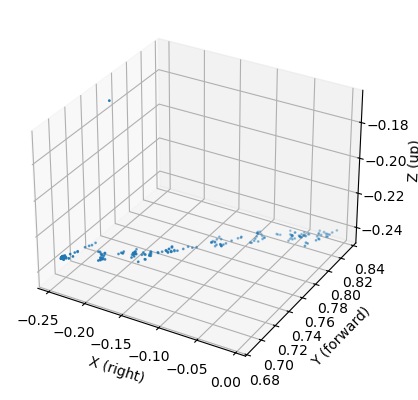

In [71]:
import matplotlib.pyplot as plt

points = np.array(np.stack(coords))  # N x 3 array of 3D world points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
ax.set_xlabel('X (right)')
ax.set_ylabel('Y (forward)')
ax.set_zlabel('Z (up)')
plt.show()

In [38]:
# Create a coordinate frame
frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)

# Visualize
o3d.visualization.draw_geometries([mesh_environment.mesh, frame])

[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x57e407326760 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


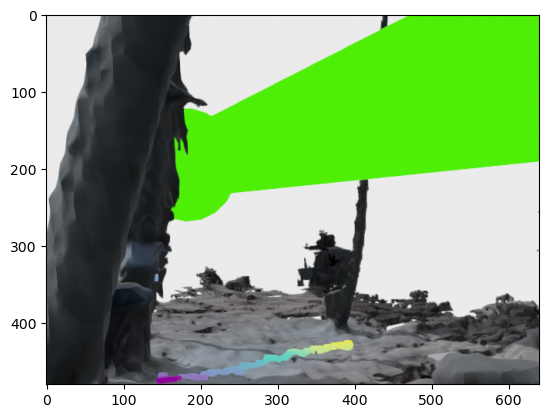

In [47]:
colors, depths = render_camera_with_points(mesh_environment.mesh, camera, points)

plt.imshow(colors)
plt.show()

In [46]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from open3d.visualization.rendering import Camera as CameraType

def render_camera_with_points(mesh: o3d.geometry.TriangleMesh,
                              camera,
                              points3d: np.ndarray = None,
                              width: int = None,
                              height: int = None):
    """
    Render an offscreen image of a mesh and optional 3D points from a given camera.

    Args:
        mesh: Open3D TriangleMesh in world coordinates
        camera: Camera object with c2w, K, width, height
        points3d: Optional (N,3) points in world coordinates
        width: Output image width
        height: Output image height

    Returns:
        color: (H,W,3) RGB image
        depth: (H,W) depth image in meters
    """
    width = width or camera.width
    height = height or camera.height

    renderer = o3d.visualization.rendering.OffscreenRenderer(width, height)
    renderer.scene.set_background([1, 1, 1, 1])

    # --- Add mesh ---
    mesh_mat = o3d.visualization.rendering.MaterialRecord()
    mesh_mat.shader = "defaultLit"
    renderer.scene.add_geometry("mesh", mesh, mesh_mat)

    # --- Add points ---
    if points3d is not None and len(points3d) > 0:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points3d)

        # Color points by depth along camera forward
        cam_pos = camera.c2w[:3, 3]
        cam_forward = camera.c2w[:3, 2]
        depths = (points3d - cam_pos) @ cam_forward
        depths_norm = (depths - depths.min()) / (depths.max() - depths.min() + 1e-8)
        colors = plt.cm.viridis(depths_norm)[:, :3]
        pcd.colors = o3d.utility.Vector3dVector(colors)

        points_mat = o3d.visualization.rendering.MaterialRecord()
        points_mat.shader = "defaultUnlit"
        points_mat.point_size = 10.0  # make points visible
        renderer.scene.add_geometry("points", pcd, points_mat)

    # --- Add world coordinate frame (optional) ---
    # if show_camera_axes:
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2)
    coord_mat = o3d.visualization.rendering.MaterialRecord()
    coord_mat.shader = "defaultUnlit"
    renderer.scene.add_geometry("world_axes", coord_frame, coord_mat)

    # Set up camera
    renderer.setup_camera(camera.K, camera.w2c, camera.width, camera.height)
    
    # --- Render ---
    color = np.asarray(renderer.render_to_image())
    depth = np.asarray(renderer.render_to_depth_image(z_in_view_space=True))
    
    # Clear geometry to avoid memory leak
    renderer.scene.clear_geometry()
    del renderer

    return color, depth

### Visualize the bboxes on the image

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

def visualize_frame_bounding_boxes(df: pd.DataFrame, frame_number: int, image: np.ndarray):
    """
    Visualize bounding boxes for a specific frame over a depth image.

    Args:
        df (pd.DataFrame): DataFrame with columns ['track_id', 'frame', 'x1', 'y1', 'x2', 'y2', 'confidence', 'class']
        frame_number (int): Frame number to visualize.
        depth_image (np.ndarray): (H, W) depth map image.
    """
    frame_df = df[df['frame'] == frame_number]

    if frame_df.empty:
        print(f"No bounding boxes found for frame {frame_number}.")
        return

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.set_title(f"Depth with Bounding Boxes (Frame {frame_number})")

    # Normalize depth for display
    # image = np.nan_to_num(image.copy())
    vmax = np.percentile(image, 95)
    vmin = np.percentile(image, 5)
    
    ax.imshow(image, cmap='viridis') #, vmin=vmin, vmax=vmax)

    for _, row in frame_df.iterrows():
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
        track_id = row['track_id']
        cls = row['class']
        conf = row['confidence']
        
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout()
    plt.show()

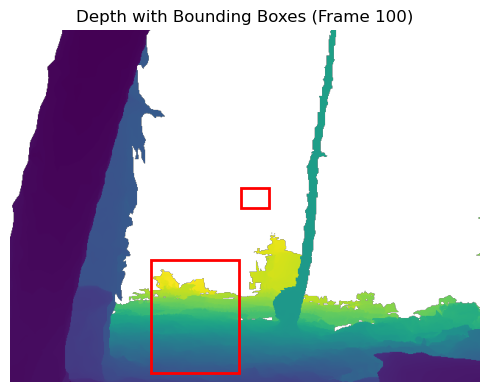

In [68]:
visualize_frame_bounding_boxes(df_tracks, 100, camera.depth)